This script is used to process the "brainwash" (human head) dataset, and to create train/val data for DetectNet.

I came accross this "brainwash" dataset when I was browsing Russell91's [TensorBox GitHub repository](https://github.com/Russell91/TensorBox). This dataset could be downloaded by:

```shell
$ wget --continue https://stacks.stanford.edu/file/druid:sx925dc9385/brainwash.tar.gz
```

This script assumes the dataset has been downloaded and extracted in the current directory. More specifically, in addition to the PNG files, there are also the annotation files, `train_boxes.json` and `val_boxes.json`, in the `brainwash` subdirectory.

```shell
$ tar xzvf brainwash_tiny.tar.gz
......
$ tree -d brainwash/
brainwash/
├── brainwash_10_27_2014_images
├── brainwash_11_13_2014_images
└── brainwash_11_24_2014_images
```

Here we do a quick check on the number of PNG files. (The number of labels actually don't match up with the number of PNG files...)

In [1]:
!ls -1 ./brainwash/brainwash_10_27_2014_images/*.png | wc -l
!ls -1 ./brainwash/brainwash_11_13_2014_images/*.png | wc -l
!ls -1 ./brainwash/brainwash_11_24_2014_images/*.png | wc -l
!grep png ./brainwash/train_boxes.json | wc -l
!grep png ./brainwash/val_boxes.json | wc -l
!grep png ./brainwash/test_boxes.json | wc -l

353
4047
7518
10769
500
500


Next, we try to do a histogram to check distribution of bounding box sizes.

Ideally we want all bouding boxes in the range of [50,50] to [400,400] for DetectNet. But its is certainly not the case for this dataset...

In [2]:
from PIL import Image
import os
import json
import random
import shutil

work_dir = './'
box_widths  = []  # widths of the boudning boxes (as specified in the JSON files)
box_heights = []  # heights of the boudning boxes (as specified in the JSON files)

input_dir = work_dir + 'brainwash/'
json_file = 'train_boxes_jk.json'

# Read json
with open(input_dir+json_file) as json_data:
    d = json.load(json_data)
    
for i in range(len(d)):
    fn =  str(d[i]['image_path'])
    # Since all PNG images are 640x480, I omit the checking below.
    #im = Image.open(os.path.join(input_dir,fn))
    #print('{}: {}x{}'.format(fn,im.size[0],im.size[1]))
    
    # Check all bounding box widths and heights
    for j in range(len(d[i]['rects'])):
        w = d[i]['rects'][j]['x2'] - d[i]['rects'][j]['x1']
        h = d[i]['rects'][j]['y2'] - d[i]['rects'][j]['y1']
        box_widths.append(w)
        box_heights.append(h)
        # highlighting bounding boxes which might be too small
        if w < 9 or h < 9:
            print('{}: x1={}, x2={}, y1={}, y2={}'.format(fn,
                  d[i]['rects'][j]['x1'], d[i]['rects'][j]['x2'],
                  d[i]['rects'][j]['y1'], d[i]['rects'][j]['y2']))

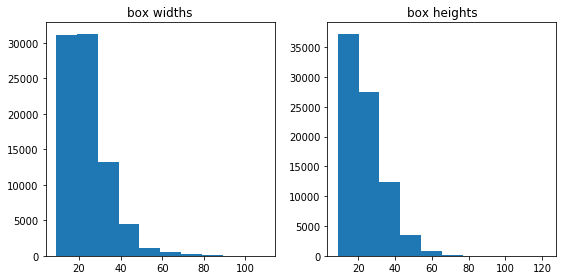

In [3]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.hist(np.array(box_widths))
plt.title('box widths')
plt.subplot(1, 2, 2)
plt.hist(np.array(box_heights))
plt.title('box heights')
plt.tight_layout()
plt.show()

min/max bounding box widths  = 109.0 /  9.0
min/max bounding box heights = 122.0 /  9.0


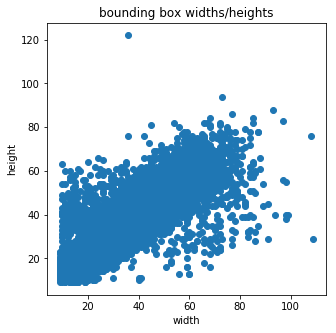

In [4]:
print('min/max bounding box widths  = {0:4.1f} / {1:4.1f}'.format(
    max(box_widths),min(box_widths)))
print('min/max bounding box heights = {0:4.1f} / {1:4.1f}'.format(
    max(box_heights),min(box_heights)))

plt.figure(figsize=(5, 5))

plt.subplot(1, 1, 1)
plt.scatter(np.array(box_widths),np.array(box_heights))
plt.title('bounding box widths/heights')
plt.xlabel('width')
plt.ylabel('height')

plt.show()

Create the output folders, and put files into them according to DetectNet formats.

```
detectnet_640x480/train/
                  ├── images/
                  │   └── brainwash_10_27_2014_images-00107000_640x480.png
                  └── labels/
                      └── brainwash_10_27_2014_images-00107000_640x480.txt
detectnet_640x480/val/
                  ├── images/
                  │   └── brainwash_11_24_2014_images-00005000_640x480.png
                  └── labels/
                      └── brainwash_11_24_2014_images-00005000_640x480.txt
```

In [5]:
# randomly pick 20% of images from the dataset as 'validation' data
val_ratio = 0.2

if os.path.exists(work_dir + 'detectnet_640x480/'):
    shutil.rmtree(work_dir + 'detectnet_640x480/')
os.makedirs(work_dir + 'detectnet_640x480/train/images/')
os.makedirs(work_dir + 'detectnet_640x480/train/labels/')
os.makedirs(work_dir + 'detectnet_640x480/val/images/')
os.makedirs(work_dir + 'detectnet_640x480/val/labels/')

In [6]:
input_dir = work_dir + 'brainwash/'
output_dir = work_dir + 'train_640x480/'
json_file = 'train_boxes_jk.json'

# Read json
with open(input_dir+json_file) as json_data:
    d = json.load(json_data)
    
for i in range(len(d)):
    fn = str(d[i]['image_path'])
    fn_out = fn.replace('/', '-')    
    output_dir = work_dir + 'detectnet_640x480/train/'
    if random.random() < val_ratio:
        output_dir = work_dir + 'detectnet_640x480/val/'
    
    # Copy the image over
    shutil.copy(input_dir+fn, output_dir+'images/'+fn_out)
    fnbase, ext = os.path.splitext(fn_out)
    # One Label file per one image
    with open(output_dir+'labels/'+fnbase+'.txt', 'w') as fp:
        # Convert annotations to required format
        for j in range(len(d[i]['rects'])):
            l = d[i]['rects'][j]['x1']
            t = d[i]['rects'][j]['y1']
            r = d[i]['rects'][j]['x2']
            b = d[i]['rects'][j]['y2']
            
            type = 'Car'
            truncated = 0
            occluded  = 3
            alpha  = 0
            tail = '0 0 0 0 0 0 0 0'
            
            label = type + ' ' +            \
                    str(truncated) + ' ' +  \
                    str(occluded)  + ' ' +  \
                    str(alpha)     + ' ' +  \
                    str(l) + ' ' + str(t) + ' ' + str(r) + ' ' + str(b) + ' ' + tail
            fp.write(label + '\n')

Verify total number of train/val images and lables.

In [7]:
!find detectnet_640x480/train/ -name "*.png" | wc -l
!find detectnet_640x480/train/ -name "*.txt" | wc -l
!find detectnet_640x480/val/ -name "*.png" | wc -l
!find detectnet_640x480/val/ -name "*.txt" | wc -l

8655
8655
2113
2113
